# Spark 분석

* Last updated 20170421 20161125

## S.1 학습내용

### S.1.1 목표

* Spark ETL을 할 수 있다.
* Spark를 사용하여 구조적 데이터를 분석할 수 있다.
* Spark를 사용하여 텍스트 분석을 할 수 있다.
* Spark를 사용하여 추천을 할 수 있다.
* Spark를 사용하여 그래프 분석을 할 수 있다.
* 시각화
    * matplotlib
    * interactive Bokeh


### S.1.2 목차

* S.2 IPython Notebook에서 SparkSession 생성하기
* S.3 데이터 타잎
* S.3.1 vectors
* S.3.2 labeled point
* S.3.3 maxtrix
* S.3.4 libsvm format
* S.4 통계

* S.5 변환 
* S.5.1 모델의 입력데이터로 변환
* S.5.2 Python을 사용한 단어 빈도 계산
* S.5.3 scikit-learn TF-IDF 
* S.5.4 StringIndexer
* S.5.5 Tokenizer
* S.5.6 RegTokenizer
* S.5.7 Stopwords
* S.5.8 CountVectorizer
* S.5.9 TF-IDF
* S.5.10 Word2Vec
* S.5.11 NGram
* S.5.12 연속데이터의 변환
* 5.5.13 VectorAssembler
* S.5.14 Pipeline

* S.6 머신러닝
* S.6.1 왜 머신러닝?
* S.6.2 라이브러리
* S.6.3 supervised vs unsupervised
* S.6.4 회귀분석
* S.6.5 군집화
* S.6.6 분류
* S.6.7 추천

* S.7 연속 데이터 분석
* S.7.1 데이터
* S.7.2 변환
* S.7.3 KMeans
* S.7.4 Regression
* S.8 구조적 데이터 분석
* S.8.1 데이터
* S.8.2 변환
* S.8.3 LogisticRegression
* S.8.4 svm
* S.8.5 Decision Tree
* S.8.6 Naive Bayesian
* S.9 텍스트 분석
* S.9.1 데이터
* S.9.2 변환
* S.9.3 LogisticRegression
* S.9.4 Decision Tree
* S.9.5 Naive Bayesian
* S.9.6 svm
* S.9.7 LDA
* S.10 추천
* S.11 scikit-learn
* S.12 그래프 분석

### S.1.3 문제 

* 문제 S-1: 훈련데이터 만들기
* 문제 S-2: Kolmogorov-Smirnov 검증
* 문제 S-3: 평균, 표준편차와 같은 기본 통계 값을 구한다.
* 문제 S-4: spark-submit

## S.2 IPython Notebook에서 SparkSession 생성하기


In [1]:
import os
import sys 
os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [4]:
spark.version

u'2.0.0'

## S.3 데이터 타잎

* Python은 데이터를 처리하면서 그 타잎을 엄격하게 따지지 않는다.
* 반면에 Spark는 데이터를 효율적으로 처리하기 위해 데이터타잎을 사용한다.
* Vector, Labeled Point, Matrix 모두 local vector이다.
* Spark의 데이터 타잎:

구분 | 설명
----------|----------
Vector | numpy vector와 같은 특징을 가진다. dense와 sparse vector로 구분한다.
Labeled Point | 클래스'label'와 속성'features'이 묶인 구조, supervised learning에 사용된다.
Matrix | 수학의 행렬에 해당한다. numpy matrix에서와 같은 특징을 가진다.

* 데이터 타잎은 Spark의 ml, mllib 패키지 별로 제공되므로, 구별하여 사용한다.

패키지 | 설명
-------|-------
mllib | RDD API를 제공한다.
ml | DataFrame API를 제공한다.

### S.3.1 vectors

* Vector는 dense와 sparse로 구분할 수 있다.
* sparse는 실제 값이 없는 요소, 즉 '0'을 제거하여 만든 vector이다.
* Spark가 효율적으로 메모리를 사용하기 위해 자동으로 변환하여 사용하기도 한다.
Spark에서 type field (1 바이트 길이)를 통해 식별한다 (0: sparse, 1: dense)


dense vector | sparse vector
----------|----------
모든 행열 값을 가지고 있다. | 인덱스 및 값의 배열을 별도로 가진다.
빈 값이 별로 없는 경우. | 빈 값이 많은 경우 사용. 
(160,69,24) | (3,[0,1,2],[160.0,69.0,24.0])<br>컬럼 3개, 값이 있는 컬럼, 값
numpy array, Python list를 입력으로 사용 | Vectors.sparse(), SciPy’s csc_matrix

* dense vectors
    * (1) Python list 또는 (2) numpy array를 dense vector로 사용할 수 있다.
    * 내부적으로 numpy.array를 사용하고 있다.

In [8]:
dv1=[0.0, 1.1, 0.1]
print dv1, type(dv1)

[0.0, 1.1, 0.1] <type 'list'>


* numpy로부터 dense vectors를 생성할 수 있다.

In [5]:
import numpy as np

dv2 = np.array([1.0, 2.1, 3.2])

In [7]:
from pyspark.mllib.linalg import Vectors
dv1mllib=Vectors.dense(dv1)
print dv1mllib, type(dv1mllib)

[0.0,1.1,0.1] <class 'pyspark.mllib.linalg.DenseVector'>


In [6]:
from pyspark.ml.linalg import Vectors
dv1ml=Vectors.dense(dv1)
print dv1ml

[0.0,1.1,0.1]


* dense vectors는 numpy array와 같은 특징을 가진다.
* 인덱스 방식으로 값을 읽을 수 있다. 또한 반복문에서 사용할 수 있다.

In [11]:
for e in dv1ml:
    print e,

0.0 1.1 0.1


* product, dot, norm과 같은 벡터 연산을 할 수도 있다.

In [12]:
print dv1ml*dv1ml
dv1ml.dot(dv1ml)

[0.0,1.21,0.01]


1.2200000000000002

* sparse vectors
    * toArray()는 sparse에서 dense로 변환할 수 있다.

In [9]:
sv1 = Vectors.sparse(3, [1, 2], [1.0, 3.0])
print sv1.toArray()

[ 0.  1.  3.]


* 참조 scipy.sparse의 Compressed Sparse Column 형식

In [4]:
import numpy as np
import scipy.sparse as sps

row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
mtx = sps.csc_matrix((data, (row, col)), shape=(3, 3))
print mtx.todense()   


[[1 0 2]
 [0 0 3]
 [4 5 6]]


### S.3.2 labeled point

* 분류 및 회귀분석에 사용되는 데이터 타잎
* 'label'과 'features'로 구성된다.
    * 'label'은 supervised learning에서 '구분 값'으로 사용한다. 데이터타잎은 'Double'
    * 'features'는 sparse, dense 모두 사용할 수 있다.

In [8]:
from pyspark.mllib.regression import LabeledPoint
print LabeledPoint(1.0, [1.0, 2.0, 3.0])

(1.0,[1.0,2.0,3.0])


In [7]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

print LabeledPoint(1992, Vectors.sparse(10, {0: 3.0, 1:5.5, 2: 10.0}))

(1992.0,(10,[0,1,2],[3.0,5.5,10.0]))


* 패키지를 혼용하는 경우 오류가 발생한다.
    * mllib LabeledPoint와 ml Vectors를 혼용하면, 형변환 오류가 발생한다.
    * 이러한 오류는 패키지를 혼용하지 않으면 된다.

```
Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector
```


In [14]:
from pyspark.mllib.regression import LabeledPoint
LabeledPoint(1.0, dv1mllib)

LabeledPoint(1.0, [0.0,1.1,0.1])

* Vectors.fromML()를 사용해 ml의 Vectors를 읽어서 mllib로 변환하여 혼용을 막는다.

In [15]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
LabeledPoint(1.0, Vectors.fromML(dv1ml))

LabeledPoint(1.0, [0.0,1.1,0.1])

* Python list에서 DataFrame 생성

In [16]:
p = [[1,[1.0,2.0,3.0]],[1,[1.1,2.1,3.1]],[0,[1.2,2.2,3.3]]]
trainDf=spark.createDataFrame(p)
trainDf.collect()

[Row(_1=1, _2=[1.0, 2.0, 3.0]),
 Row(_1=1, _2=[1.1, 2.1, 3.1]),
 Row(_1=0, _2=[1.2, 2.2, 3.3])]

* Python list를 LabeledPoint로 생성하면, 'label'과 'features'의 명칭을 가지도록 생성된다.

In [9]:
from pyspark.mllib.regression import LabeledPoint
p = [LabeledPoint(1,[1.0,2.0,3.0]),
     LabeledPoint(1,[1.1,2.1,3.1]),
     LabeledPoint(0,[1.2,2.2,3.3])]
trainDf=spark.createDataFrame(p)
trainDf.collect()

[Row(features=DenseVector([1.0, 2.0, 3.0]), label=1.0),
 Row(features=DenseVector([1.1, 2.1, 3.1]), label=1.0),
 Row(features=DenseVector([1.2, 2.2, 3.3]), label=0.0)]

In [10]:
from pyspark.mllib.linalg import Vectors

trainDf = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, 1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, 0.5]))], ["label", "features"])
trainDf.collect()

[Row(label=1.0, features=DenseVector([0.0, 1.1, 0.1])),
 Row(label=0.0, features=DenseVector([2.0, 1.0, 1.0])),
 Row(label=0.0, features=DenseVector([2.0, 1.3, 1.0])),
 Row(label=1.0, features=DenseVector([0.0, 1.2, 0.5]))]

* schema를 사용해서 DataFrame 생성하기
    * 'label'은 DoubleType
    * 'features'는 VectorType

In [3]:
from pyspark.mllib.linalg import SparseVector, VectorUDT
from pyspark.sql.types import StructType, StructField, DoubleType
_rdd = spark.sparkContext.parallelize([
    (0.0, SparseVector(4, {1: 1.0, 3: 5.5})),
    (1.0, SparseVector(4, {0: -1.0, 2: 0.5}))])

schema = StructType([
    StructField("label", DoubleType(), True),
    StructField("features", VectorUDT(), True)
])

trainDf=_rdd.toDF(schema)
trainDf.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



* 사용자 함수udf User Defined Type를 사용하여 sparse vector를 dense vector로 변환해 보기
    * 바로 변환할 수 있는 함수 toDense()를 지원하지 않는다.
    * 따라서, sparse vector -> toArray() -> dense vector의 차례로 변환한다.

* sparse vector를 -> toArray()로 변환하는 함수를 사용할 수 있다.

In [39]:
from pyspark.ml.linalg import Vectors
#from pyspark.mllib.linalg import Vectors
sv1 = Vectors.sparse(3, [1, 2], [1.0, 3.0])
print type(sv1),sv1.toArray()

<class 'pyspark.ml.linalg.SparseVector'> [ 0.  1.  3.]


* 사용자 변환함수 udf()를 사용한다.
* trainDf는 mllib RDD에서 변환된 데이터이므로, mllib 라이브러리를 사용한다.
    * (1) sparse vector로 구성된 trainDf.features를 toArray()를 사용하여 array로 변환한다.
        * VectorUDT()로 타잎을 지정한다. 
            * 지정하지 않으면 StringType을 기본으로, 자동으로 변환된다.
    * (2) DenseVector()를 사용하여 array를 dense vector로 변환한다.

구분 | 설명
-----|-----
from pyspark.mllib.linalg import DenseVector,VectorUDT | mllib
from pyspark.ml.linalg import DenseVector,VectorUDT | ml

In [4]:
from pyspark.sql.functions import udf
#from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.mllib.linalg import DenseVector, VectorUDT
#myudf=udf(lambda x: Vectors.dense(x), VectorUDT())
#myudf=udf(lambda x: Vectors.dense(x))
myudf=udf(lambda x: DenseVector(x.toArray()), VectorUDT())
_trainDf2=trainDf.withColumn('dvf',myudf(trainDf.features))

In [5]:
_trainDf2.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- dvf: vector (nullable = true)



In [6]:
_trainDf2.show()

+-----+--------------------+------------------+
|label|            features|               dvf|
+-----+--------------------+------------------+
|  0.0| (4,[1,3],[1.0,5.5])| [0.0,1.0,0.0,5.5]|
|  1.0|(4,[0,2],[-1.0,0.5])|[-1.0,0.0,0.5,0.0]|
+-----+--------------------+------------------+



* Rating
    * 추천에서 사용한다.
    * 사용자, 제품, 평가 항목으로 구성한다.


In [20]:
from pyspark.mllib.recommendation import Rating
Rating(1, 2, 5.0)

Rating(user=1, product=2, rating=5.0)

### S.3.3 maxtrix

* local matrix - pyspark.mllib.linalg.Matrix, Matrices
* distributed matrix
    * pyspark.mllib.linalg.distributed.RowMatrix
    * pyspark.mllib.linalg.distributed.IndexedRow, IndexedRowMatrix
    * pyspark.mllib.linalg.distributed.BlockMatrix

In [21]:
from pyspark.mllib.linalg import Matrix, Matrices

# Create a dense matrix ((1.0, 2.0), (3.0, 4.0), (5.0, 6.0))
dm = Matrices.dense(3, 2, [1, 2, 3, 4, 5, 6])

# Create a sparse matrix ((9.0, 0.0), (0.0, 8.0), (0.0, 6.0))
sm = Matrices.sparse(3, 2, [0, 1, 3], [0, 2, 1], [9, 6, 8])

## 문제 S-1: 훈련데이터 만들기

* 공백으로 구분된 데이터를 식별하여 labeled point로 변환한다.
* 읽을 대상이 파일이므로, RDD를 사용한다.

* 데이터 읽기
    * 파일이 존재하는지 확인

In [21]:
import os
#_fp=os.path.join(spark_home,"data/mllib/sample_svm_data.txt")
_fp=os.path.join(os.environ["SPARK_HOME"],\
                 'data','mllib','sample_svm_data.txt')
print os.path.isfile(_fp)

True


In [22]:
_f=open(_fp,'r')
_lines=_f.readlines()
print _lines[0]
_f.close()

1 0 2.52078447201548 0 0 0 2.004684436494304 2.000347299268466 0 2.228387042742021 2.228387042742023 0 0 0 0 0 0



In [24]:
_rdd=spark.sparkContext.textFile(_fp)\
    .map(lambda line: [float(x) for x in line.split(' ')])
_rdd.take(1)[0]

[1.0,
 0.0,
 2.52078447201548,
 0.0,
 0.0,
 0.0,
 2.004684436494304,
 2.000347299268466,
 0.0,
 2.228387042742021,
 2.228387042742023,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [25]:
from pyspark.mllib.regression import LabeledPoint

_trainRdd0=_rdd.map(lambda line:LabeledPoint(line[0], line[1:]))
_trainRdd0.take(1)

[LabeledPoint(1.0, [0.0,2.52078447202,0.0,0.0,0.0,2.00468443649,2.00034729927,0.0,2.22838704274,2.22838704274,0.0,0.0,0.0,0.0,0.0,0.0])]

* 공백을 분리하고, 분리된 데이터를 labeled point로 구성하는 기능을 합쳐서 실행해 본다.

In [27]:
_trainRdd=spark.sparkContext.textFile(_fp)\
    .map(lambda line: [float(x) for x in line.split(' ')])\
    .map(lambda p:LabeledPoint(p[0], p[1:]))
_trainRdd.take(1)

[LabeledPoint(1.0, [0.0,2.52078447202,0.0,0.0,0.0,2.00468443649,2.00034729927,0.0,2.22838704274,2.22838704274,0.0,0.0,0.0,0.0,0.0,0.0])]

* 다른 방식으로, 함수를 사용해서 변환해 본다.
* 함수는 변환절차가 복잡할 경우 사용하면 편리하다.

In [29]:
def createLP(line):
    p = [float(x) for x in line.split(' ')]
    return LabeledPoint(p[0], p[1:])

_rdd=spark.sparkContext.textFile(_fp)
trainRdd = _rdd.map(createLP)

trainRdd.take(1)

[LabeledPoint(1.0, [0.0,2.52078447202,0.0,0.0,0.0,2.00468443649,2.00034729927,0.0,2.22838704274,2.22838704274,0.0,0.0,0.0,0.0,0.0,0.0])]

### S.3.4 libsvm format

* svm을 처리하기 위한 데이터 형식이다.
* 0은 label, 나머지는 index:value 쌍으로 구성한다.
```
[label] [index1]:[value1] [index2]:[value2] ...
[label] [index1]:[value1] [index2]:[value2] ...
```

* 예
```
0 128:51 129:159 130:253 131:159 132:50 155:48 156:238 157:252 158:252 159:252 160:237 182:54 183:227 184:253 185:252 186:239 187:233 ...
```


In [28]:
fsvm=os.path.join(os.environ["SPARK_HOME"],'data','mllib','sample_libsvm_data.txt')
dfsvm = spark.read.format("libsvm").load(fsvm)

In [29]:
type(dfsvm)

pyspark.sql.dataframe.DataFrame

In [30]:
dfsvm.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [31]:
dfsvm.take(1)

[Row(label=0.0, features=SparseVector(692, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0

## S.4 통계

* mllib 모듈을 사용한다 'pyspark.mllib.stat'
* 기본 통계
* 가설 검증
* 상관관계 - 키와 몸무게의 상관관계

## 문제 S-2:  Kolmogorov-Smirnov 검증

In [9]:
from pyspark.mllib.stat import Statistics

parallelData = spark.sparkContext.parallelize([1.0, 2.0, 5.0, 4.0, 3.0, 3.3, 5.5])

# run a KS test for the sample versus a standard normal distribution
testResult = Statistics.kolmogorovSmirnovTest(parallelData, "norm", 0, 1)
print(testResult)

Kolmogorov-Smirnov test summary:
degrees of freedom = 0 
statistic = 0.841344746068543 
pValue = 5.06089025353873E-6 
Very strong presumption against null hypothesis: Sample follows theoretical distribution.


## 문제 S-3:  평균, 표준편차와 같은 기본 통계 값을 구한다.

* 통계에 '무작위' 수는 중요하다. 무작위 샘플, 무작위 수를 발생하여 확률에서 빈번하게 사용한다.

* DataFrame에서 제공하는 통계 기능을 사용해 본다.
* 컬럼 3개의 DataFrame을 생성한다.
    * 첫 컬럼은 'id', SparkSession.range()를 사용한다.
    * 무작위 수를 추출해서, 나머지 컬럼 데이터를 만든다. pyspark.sql.functions 함수를 사용한다.
    * rand()는 Uniform분포, randn()은 정규분포를 사용한다.

In [3]:
df = spark.range(0,10)
df.show()
df.select('id')

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



DataFrame[id: bigint]

In [5]:
from pyspark.sql.functions import rand, randn
colUniform = rand(seed=10).alias("uniform")
colNormal=randn(seed=27).alias("normal")
df3=df.select("id", colUniform,colNormal)
df3.show()

+---+-------------------+-------------------+
| id|            uniform|             normal|
+---+-------------------+-------------------+
|  0|0.41371264720975787| 0.5888539012978773|
|  1| 0.7311719281896606| 0.8645537008427937|
|  2| 0.9031701155118229| 1.2524569684217643|
|  3|0.09430205113458567| -2.573636861034734|
|  4|0.38340505276222947| 0.5469737451926588|
|  5| 0.5569246135523511|0.17431283601478723|
|  6| 0.4977441406613893|-0.7040284633147095|
|  7| 0.2076666106201438| 0.4637547571868822|
|  8| 0.9571919406508957|  0.920722532496133|
|  9| 0.7429395461204413|-1.4353459012380192|
+---+-------------------+-------------------+



* 각 컬럼별로 통계 값을 계산할 수 있다.

In [6]:
df3.describe().show()

+-------+------------------+-------------------+--------------------+
|summary|                id|            uniform|              normal|
+-------+------------------+-------------------+--------------------+
|  count|                10|                 10|                  10|
|   mean|               4.5| 0.5488228646413278|0.009861721586543392|
| stddev|3.0276503540974917| 0.2856822245344392|  1.2126061129356596|
|    min|                 0|0.09430205113458567|  -2.573636861034734|
|    max|                 9| 0.9571919406508957|  1.2524569684217643|
+-------+------------------+-------------------+--------------------+



* 무작위 수 2 컬럼을 만들어, 상관관계를 계산한다.
* 자신과의 상관관계는 당연히 1.0이 된다.

In [7]:
df = spark.range(0, 10).withColumn('rand1', rand(seed=10)).withColumn('rand2', rand(seed=27))
print df.stat.corr('rand1', 'rand2')
print df.stat.corr('id', 'id')

-0.109939624671
1.0


* freqItems()
    * a, b, c 세 컬럼에 대해 60%이상 발생한 데이터를 출력

In [4]:
df=spark.createDataFrame([(1,2,3) if i%2==0 else (i,2*i,i%4) for i in range(100)],["a","b","c"])
df.show(5)

+---+---+---+
|  a|  b|  c|
+---+---+---+
|  1|  2|  3|
|  1|  2|  1|
|  1|  2|  3|
|  3|  6|  3|
|  1|  2|  3|
+---+---+---+
only showing top 5 rows



In [16]:
freq = df.stat.freqItems(["a","b","c"],0.6)
print freq.show()

+-----------+-----------+-----------+
|a_freqItems|b_freqItems|c_freqItems|
+-----------+-----------+-----------+
|        [1]|        [2]|        [3]|
+-----------+-----------+-----------+

None


## S.5 변환

* Spark의 ETL (Etract, Transform, Load)은 다양한 입력에서 데이터를 추출, 변환하여 예측, 분류, 군집화, 추천과 같은 모델에 사용하게 된다.
* RDD는 map-reduce와 같은 transform, action을 사용한다.
* DataFrame은 Transformer, Estimator를 사용한다.
* Pipeline은 여러 Estimator를 묶은 Estimator를 반환한다. 단계적으로 Estimator를 적용하기 위해 사용한다.

변환 기능 | 설명 | 함수
----------|----------|----------
Estimator | 모델의 인자를 설정, 데이터에 적용한다. Transformer를 반환한다.| Estimator.fit()
Transformer | 열을 선택, 변환한다. 그 결과를 DataFrame으로 반환한다. | Transformer.transform()


### S.5.1 모델의 입력데이터로 변환

* 군집화, 회귀분석, 분류, 추천 모델에 사용되는 데이터는 '일련의 수' 또는 '텍스트'로 구성된다.
* 특징을 추출하여 feature vectors를 구성한다.
* 분류를 하는 경우에는 class 또는 label 값이 필요하다.
* 텍스트는 'bag of words'으로 표현한다.
    * 문서는 단어로 구성된다.
    * 단어의 순서는 의미를 가지지 않는다.
    
구분 | 설명 | 예
----------|----------|----------|
corpus | 문서 집합 | "why she had to go", "where she have to go"
document | 레코드 | "why she had to go"
vocabularay | 중복없는 단어 집합 | "why","she","had","to","go","where","have"
word vector | 있다-없다, 단어빈도, TFIDF 사용할 수 있다.<br>dense, sparse 모두 가능하다. | [1,1,1,1,1,0,0],[0,1,0,1,1,1,1]


* 데이터의 구성
    * 데이터 컬럼 명은 'lableCol', 'featureCol'으로 설정해서 사용할 수 있다.
    * 기본 컬럼 명을 사용하는 경우:
        * DataFrame은 'label' (DoubleType), 'features' (sparse or dense vectors)
        * Rdd는 LabeledPoint
* 데이터 정련
    * 결측 값, 범위를 벗어나는 outlier, 
    * trainRDD에 마이너스 값 nok?!

### S.5.2 Python을 사용한 단어 빈도 계산

In [23]:
# Let it be 가사
doc=[
    "When I find myself in times of trouble",
    "Mother Mary comes to me",
    "Speaking words of wisdom, let it be",
    "And in my hour of darkness",
    "She is standing right in front of me",
    "Speaking words of wisdom, let it be",
    "Let it be",
    "Let it be",
    "Let it be",
    "Let it be",
    "Whisper words of wisdom, let it be"
]
d={}
for sentence in doc:
    words=sentence.split()
    for word in words:
        if word in d:
            d[word]+=1
        else:
            d[word]=1
for k,v in d.iteritems():
    print k,v

right 1
be 7
is 1
When 1
it 7
in 3
Mary 1
Speaking 2
standing 1
darkness 1
find 1
wisdom, 3
to 1
Let 4
And 1
I 1
let 3
She 1
words 3
Mother 1
front 1
trouble 1
me 2
myself 1
hour 1
of 6
times 1
Whisper 1
my 1
comes 1


### S.5.3 scikit-learn TF-IDF

* TfidfTransformer는 TF-IDF(Term Frequency-Inverse Document Frequency)를 계산한다.
    * 단계 1: Tokenizer를 사용하여 문장을 단어로 분리 
    * 단계 2: CountVectorizer를 사용하여 단어의 빈도수tf를 계산
    * 단계 3: HashingTF를 사용하여 'word vector'를 계산.
    HashingTF은 hash함수에 따라 단어의 고유번호를 생성,
    hash고유번호의 충돌 가능성을 줄이기 위해, 단어 수를 제한할 수 있다.
    * 단계 4: IDF를 계산
    * 단계 4: TF-IDF를 계산 

#### S.5.2.1 TF-IDF 계산

* 'Let it be'가사 세 번째 줄 'wisdom'단어의 TF-IDF: 2.09861228867
* TF-IDF를 'TfidfVectorizer'를 사용해서 곧 계산하면 그 결과를 볼 수 있다. 

```
(2,12) 2.09861228867 <-- 2는 doc의 id (즉 3번째 문서), 12는 'wisdom'의 id (즉 단어의 id)
```

* 3번째 문장의 word vector를 구성해 본다.
* id값은 모든 문장에서 단어를 추출하고 나서야 부여될 수 있다.

words | id | 빈도 | 
-----|-----|-----
Speaking | 7 | 1
words | 13 | 1
of | stopword | 0
wisdom | 12 | 1
let | 3 | 1
it | stopword | 0
be | stopword | 0

* 위 word vector를 표로 나타내면 아래와 같다. 다른 행과 열은 이해를 돕기 위해 비워 놓았다.

doc   | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |10 |11 |12 |13 |...
------|---|---|---|---|---|---|---|---|---|---|---|---|---|---
doc 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |...
doc 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |...
doc 2 | 1 |   |   |   |   |   | 1 |   |   |   |   | 1 | 1 |...
...   |   |   |   |   |   |   |   |   |   |   |   |   |   |...

* TF-IDF 계산

항목 | 설명 | 예제
-----|-----|-----
tf | term frequency 단어의 빈도 수 | $f_{t,d}$ / (number of words in d) = 1/4 = 0.25<br>(3번째 문서에 stopwords를 제외하면 4개의 단어, wisdom은 1회 나타난다.)
df | document frequency 단어가 나타난 문서 수 | 3 (wisdom이 포함된 문서는 3)
N | number of documents 전체 문서의 수 | 11 (전체의 문서는 11개)
idf | inverse document frequency 단어가 나타난 문서의 비율을 거꾸로 | ln(N+1 / df+1) + 1 = log(12/4) + 1 = 1.09861 + 1<br>0으로 나뉘는 것을 방지하기 위해 smoothing, 즉 1을 더한다. 

In [72]:
import math
tf=1./4
df=3.
N=11.
idf=math.log((N+1)/(df+1))+1
print idf

2.09861228867


#### S.5.2.2 sklearn을 사용한 TF-IDF

* Spark는 'sklearn'의 TF-IDF와 동일한 방식으로 계산한다.
* CountVectorizer를 사용하여, 문서 x 단어를 표로 계산결과를 출력할 수 있다.
* 그 다음으로, TF-IDF를 계산할 수 있다. 이 때 (문서id, 단어id) 별로 결과가 출력된다.

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
vectorizer = CountVectorizer()
print vectorizer.fit_transform(doc).todense()
print vectorizer.vocabulary_

[[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
 [1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1]]
{u'and': 0, u'be': 1, u'right': 17, u'whisper': 25, u'is': 8, u'it': 9, u'wisdom': 26, u'me': 12, u'let': 10, u'words': 27, u'in': 7, u'front': 5, u'trouble': 23, u'find': 4, u'standing': 20, u'comes': 2, u'myself': 15, u'darkness': 3, u'hour': 6, u'of': 16, u'when': 24, u'times': 21, u'to': 22, u'she': 18, u'mother': 13, u'my': 14, u'mary': 11, u'

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english',norm = None)

print vectorizer.fit_transform(doc)
print vectorizer.vocabulary_
print vectorizer.idf_


  (0, 10)	2.79175946923
  (0, 9)	2.79175946923
  (1, 0)	2.79175946923
  (1, 4)	2.79175946923
  (1, 5)	2.79175946923
  (2, 3)	1.40546510811
  (2, 12)	2.09861228867
  (2, 13)	2.09861228867
  (2, 7)	2.38629436112
  (3, 1)	2.79175946923
  (3, 2)	2.79175946923
  (4, 6)	2.79175946923
  (4, 8)	2.79175946923
  (5, 3)	1.40546510811
  (5, 12)	2.09861228867
  (5, 13)	2.09861228867
  (5, 7)	2.38629436112
  (6, 3)	1.40546510811
  (7, 3)	1.40546510811
  (8, 3)	1.40546510811
  (9, 3)	1.40546510811
  (10, 11)	2.79175946923
  (10, 3)	1.40546510811
  (10, 12)	2.09861228867
  (10, 13)	2.09861228867
{u'standing': 8, u'right': 6, u'darkness': 1, u'hour': 2, u'whisper': 11, u'times': 9, u'let': 3, u'speaking': 7, u'words': 13, u'mother': 5, u'trouble': 10, u'wisdom': 12, u'mary': 4, u'comes': 0}
[ 2.79175947  2.79175947  2.79175947  1.40546511  2.79175947  2.79175947
  2.79175947  2.38629436  2.79175947  2.79175947  2.79175947  2.79175947
  2.09861229  2.09861229]


* doc를 list of list로 만들어, DataFrame을 생성한다.
* schema는 만들어 주지 않아도 된다.


In [4]:
doc=[
    ["When I find myself in times of trouble"],
    ["Mother Mary comes to me"],
    ["Speaking words of wisdom, let it be"],
    ["And in my hour of darkness"],
    ["She is standing right in front of me"],
    ["Speaking words of wisdom, let it be"],
    [u"우리 Let it be"],
    [u"나 Let it be"],
    [u"너 Let it be"],
    ["Let it be"],
    ["Whisper words of wisdom, let it be"]
]

myDf=spark.createDataFrame(doc,['sent'])
myDf.show(truncate=False)

+--------------------------------------+
|sent                                  |
+--------------------------------------+
|When I find myself in times of trouble|
|Mother Mary comes to me               |
|Speaking words of wisdom, let it be   |
|And in my hour of darkness            |
|She is standing right in front of me  |
|Speaking words of wisdom, let it be   |
|우리 Let it be                          |
|나 Let it be                           |
|너 Let it be                           |
|Let it be                             |
|Whisper words of wisdom, let it be    |
+--------------------------------------+



### S.5.4 StringIndexer

* 문자를 인덱스 값, double로 변환된다.

구분 | 설명 | 예
-----|-----|-----
nominal | 명목 또는 구분 값 cateogry  | 사자, 호랑이, 사람
ordinal | 명목값과 다른 점은 순서가 있다. | 키 low, med, high
interval | 일정한 간격이 있다. | 150-165, 165-180, 180-195


In [38]:
from pyspark.ml.feature import StringIndexer
labelIndexer = StringIndexer(inputCol="sent", outputCol="sentLabel")
model=labelIndexer.fit(myDf)
siDf=model.transform(myDf)
siDf.show()

+--------------------+---------+
|                sent|sentLabel|
+--------------------+---------+
|When I find mysel...|      9.0|
|Mother Mary comes...|      8.0|
|Speaking words of...|      0.0|
|And in my hour of...|      5.0|
|She is standing r...|      4.0|
|Speaking words of...|      0.0|
|        우리 Let it be|      6.0|
|         나 Let it be|      1.0|
|         너 Let it be|      2.0|
|           Let it be|      7.0|
|Whisper words of ...|      3.0|
+--------------------+---------+



#### S.5.5 Tokenizer

* 문장을 단어와 같은 token으로 분리한다.
* 단어는 배열로 구성한다. 요소는 string이다.

In [40]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="sent", outputCol="words")
tokDf = tokenizer.transform(myDf)
for r in tokDf.select("sent", "words").take(3):
    print r

Row(sent=u'When I find myself in times of trouble', words=[u'when', u'i', u'find', u'myself', u'in', u'times', u'of', u'trouble'])
Row(sent=u'Mother Mary comes to me', words=[u'mother', u'mary', u'comes', u'to', u'me'])
Row(sent=u'Speaking words of wisdom, let it be', words=[u'speaking', u'words', u'of', u'wisdom,', u'let', u'it', u'be'])


#### S.5.6 RegTokenizer

* 단어를 분리하기 위한 패턴을 적용할 수 있다.
* 한글에는 \w 패턴이 적용되지 않는다. 
* 공백 \s 패턴을 적용한다.


In [6]:
from pyspark.ml.feature import RegexTokenizer
re = RegexTokenizer(inputCol="sent", outputCol="wordsReg", pattern="\\s+")
reDf=re.transform(myDf)
reDf.show()

+--------------------+--------------------+
|                sent|            wordsReg|
+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|
|Mother Mary comes...|[mother, mary, co...|
|Speaking words of...|[speaking, words,...|
|And in my hour of...|[and, in, my, hou...|
|She is standing r...|[she, is, standin...|
|Speaking words of...|[speaking, words,...|
|        우리 Let it be|   [우리, let, it, be]|
|         나 Let it be|    [나, let, it, be]|
|         너 Let it be|    [너, let, it, be]|
|           Let it be|       [let, it, be]|
|Whisper words of ...|[whisper, words, ...|
+--------------------+--------------------+



#### S.5.7 Stopwords

* 한 단어 등 불용어.
* http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words

In [200]:
from pyspark.ml.feature import StopWordsRemover
stop = StopWordsRemover(inputCol="wordsReg", outputCol="nostops")

* 현재 stop words에 자신의 것을 추가해서, 재설정한다.

In [202]:
stopwords=list()
_stopwords=stop.getStopWords()
for e in _stopwords:
    stopwords.append(e)

_mystopwords=[u"나",u"너", u"우리"]
for e in _mystopwords:
    stopwords.append(e)
stop.setStopWords(stopwords)

StopWordsRemover_48ffb76d20f86d50eaea

In [203]:
for e in stop.getStopWords():
    print e,

i me my myself we our ours ourselves you your yours yourself yourselves he him his himself she her hers herself it its itself they them their theirs themselves what which who whom this that these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don should now d ll m o re ve y ain aren couldn didn doesn hadn hasn haven isn ma mightn mustn needn shan shouldn wasn weren won wouldn 나 너 우리


* 한글의 stop words '너','우리'가 제거되었다.

In [204]:
stopDf=stop.transform(reDf)
stopDf.show()

+--------------------+--------------------+--------------------+
|                sent|            wordsReg|             nostops|
+--------------------+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|[find, times, tro...|
|Mother Mary comes...|[mother, mary, co...|[mother, mary, co...|
|Speaking words of...|[speaking, words,...|[speaking, words,...|
|And in my hour of...|[and, in, my, hou...|    [hour, darkness]|
|She is standing r...|[she, is, standin...|[standing, right,...|
|Speaking words of...|[speaking, words,...|[speaking, words,...|
|        우리 Let it be|   [우리, let, it, be]|               [let]|
|         나 Let it be|    [나, let, it, be]|               [let]|
|         너 Let it be|    [너, let, it, be]|               [let]|
|           Let it be|       [let, it, be]|               [let]|
|Whisper words of ...|[whisper, words, ...|[whisper, words, ...|
+--------------------+--------------------+--------------------+



#### S.5.8 CountVectorizer

* 입력: a collection of text documents
* 출력: word vector (sparse) vocabulary x TF
* tokenize하고 나서 사용
* minDF
    * 소수점은 비율, 사용된 문서 수/전체 문서 수
        * 정수는 사용된 문서 수, 단어가 몇 개의 문서에 사용되어야 하는지


In [205]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="nostops", outputCol="cv",
    vocabSize=30,minDF=1.0)
cvModel = cv.fit(stopDf)
cvDf = cvModel.transform(stopDf)

cvDf.collect()
cvDf.select('sent','nostops','cv').show()
for v in cvModel.vocabulary:
    print v,

+--------------------+--------------------+--------------------+
|                sent|             nostops|                  cv|
+--------------------+--------------------+--------------------+
|When I find mysel...|[find, times, tro...|(16,[5,6,8],[1.0,...|
|Mother Mary comes...|[mother, mary, co...|(16,[10,13,14],[1...|
|Speaking words of...|[speaking, words,...|(16,[0,1,2,3],[1....|
|And in my hour of...|    [hour, darkness]|(16,[7,9],[1.0,1.0])|
|She is standing r...|[standing, right,...|(16,[4,12,15],[1....|
|Speaking words of...|[speaking, words,...|(16,[0,1,2,3],[1....|
|        우리 Let it be|               [let]|      (16,[0],[1.0])|
|         나 Let it be|               [let]|      (16,[0],[1.0])|
|         너 Let it be|               [let]|      (16,[0],[1.0])|
|           Let it be|               [let]|      (16,[0],[1.0])|
|Whisper words of ...|[whisper, words, ...|(16,[0,1,2,11],[1...|
+--------------------+--------------------+--------------------+

let wisdom, words speaki

#### S.5.9 TF-IDF

* Term frequency-inverse document frequency (TF-IDF)
* tokenizer하고 나서 사용해야 함. 
*  HashingTF  고정길이 word vectors.
* IDF 

In [206]:
from pyspark.ml.feature import HashingTF, IDF

hashTF = HashingTF(inputCol="nostops", outputCol="hash", numFeatures=50)
hashDf = hashTF.transform(stopDf)
idf = IDF(inputCol="hash", outputCol="idf")
idfModel = idf.fit(hashDf)
idfDf = idfModel.transform(hashDf)
for e in idfDf.select("nostops","hash").take(10):
    print(e)

Row(nostops=[u'find', u'times', u'trouble'], hash=SparseVector(50, {10: 1.0, 24: 1.0, 43: 1.0}))
Row(nostops=[u'mother', u'mary', u'comes'], hash=SparseVector(50, {1: 1.0, 21: 1.0, 24: 1.0}))
Row(nostops=[u'speaking', u'words', u'wisdom,', u'let'], hash=SparseVector(50, {9: 1.0, 12: 1.0, 14: 1.0, 41: 1.0}))
Row(nostops=[u'hour', u'darkness'], hash=SparseVector(50, {23: 1.0, 27: 1.0}))
Row(nostops=[u'standing', u'right', u'front'], hash=SparseVector(50, {24: 1.0, 43: 1.0, 46: 1.0}))
Row(nostops=[u'speaking', u'words', u'wisdom,', u'let'], hash=SparseVector(50, {9: 1.0, 12: 1.0, 14: 1.0, 41: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))


#### S.5.10 Word2Vec

* see wikipedia https://en.wikipedia.org/wiki/Word2vec

In [207]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=3,minCount=0,inputCol="words",outputCol="w2v")
model = word2Vec.fit(tokDf)
w2vDf = model.transform(tokDf)
for e in w2vDf.select("w2v").take(3):
    print(e)

Row(w2v=DenseVector([-0.0367, 0.0097, 0.0479]))
Row(w2v=DenseVector([-0.0482, 0.0223, 0.0095]))
Row(w2v=DenseVector([0.052, -0.001, -0.0019]))


#### S.5.11 NGram

* unigram은 한 단어로, bigram은 두 단어로 구성한다.

In [41]:
from pyspark.ml.feature import NGram
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")
ngramDf = ngram.transform(tokDf)
ngramDf.show()
for e in ngramDf.select("words","ngrams").take(3):
    print e

+--------------------+--------------------+--------------------+
|                sent|               words|              ngrams|
+--------------------+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|[when i, i find, ...|
|Mother Mary comes...|[mother, mary, co...|[mother mary, mar...|
|Speaking words of...|[speaking, words,...|[speaking words, ...|
|And in my hour of...|[and, in, my, hou...|[and in, in my, m...|
|She is standing r...|[she, is, standin...|[she is, is stand...|
|Speaking words of...|[speaking, words,...|[speaking words, ...|
|        우리 Let it be|   [우리, let, it, be]|[우리 let, let it, ...|
|         나 Let it be|    [나, let, it, be]|[나 let, let it, i...|
|         너 Let it be|    [너, let, it, be]|[너 let, let it, i...|
|           Let it be|       [let, it, be]|     [let it, it be]|
|Whisper words of ...|[whisper, words, ...|[whisper words, w...|
+--------------------+--------------------+--------------------+

Row(words=[u'when', u'i'

#### S.5.12 연속데이터의 변환

* 연속 데이터 - 몸무게(inches), 키(pounds)


In [67]:
from pyspark.sql.types import *
rdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

myRdd=rdd.map(lambda line:[float(x) for x in line.split('\t')])
myDf=spark.createDataFrame(myRdd,["id","weight","height"])

In [54]:
myDf.printSchema()

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)



In [68]:
from pyspark.ml.feature import Binarizer
binarizer = Binarizer(threshold=68.0, inputCol="weight", outputCol="weight2")
binDf = binarizer.transform(myDf)
binDf.show(10)

+----+------+------+-------+
|  id|weight|height|weight2|
+----+------+------+-------+
| 1.0| 65.78|112.99|    0.0|
| 2.0| 71.52|136.49|    1.0|
| 3.0|  69.4|153.03|    1.0|
| 4.0| 68.22|142.34|    1.0|
| 5.0| 67.79| 144.3|    0.0|
| 6.0|  68.7| 123.3|    1.0|
| 7.0|  69.8|141.49|    1.0|
| 8.0| 70.01|136.46|    1.0|
| 9.0|  67.9|112.37|    0.0|
|10.0| 66.78|120.67|    0.0|
+----+------+------+-------+
only showing top 10 rows



In [69]:
from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=3, inputCol="height", outputCol="height3")
qdDf = discretizer.fit(binDf).transform(binDf)
qdDf.show(10)


+----+------+------+-------+-------+
|  id|weight|height|weight2|height3|
+----+------+------+-------+-------+
| 1.0| 65.78|112.99|    0.0|    0.0|
| 2.0| 71.52|136.49|    1.0|    1.0|
| 3.0|  69.4|153.03|    1.0|    2.0|
| 4.0| 68.22|142.34|    1.0|    2.0|
| 5.0| 67.79| 144.3|    0.0|    2.0|
| 6.0|  68.7| 123.3|    1.0|    0.0|
| 7.0|  69.8|141.49|    1.0|    2.0|
| 8.0| 70.01|136.46|    1.0|    1.0|
| 9.0|  67.9|112.37|    0.0|    0.0|
|10.0| 66.78|120.67|    0.0|    0.0|
+----+------+------+-------+-------+
only showing top 10 rows



#### 5.5.13 VectorAssembler

* 열을 묶어서 Vector열로 만든다.
* string은 묶을 수 없다.
* pyspark.ml.linalg.Vectors를 사용한다. (주의: pyspark.mllib.linalg.Vectors를 사용하지 않는다.)

In [70]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["weight2","height3"],outputCol="features")
vaDf = va.transform(qdDf)
vaDf.printSchema()
vaDf.show(5)

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)
 |-- weight2: double (nullable = true)
 |-- height3: double (nullable = true)
 |-- features: vector (nullable = true)

+---+------+------+-------+-------+---------+
| id|weight|height|weight2|height3| features|
+---+------+------+-------+-------+---------+
|1.0| 65.78|112.99|    0.0|    0.0|(2,[],[])|
|2.0| 71.52|136.49|    1.0|    1.0|[1.0,1.0]|
|3.0|  69.4|153.03|    1.0|    2.0|[1.0,2.0]|
|4.0| 68.22|142.34|    1.0|    2.0|[1.0,2.0]|
|5.0| 67.79| 144.3|    0.0|    2.0|[0.0,2.0]|
+---+------+------+-------+-------+---------+
only showing top 5 rows



#### S.5.14 Pipeline

* Pipeline은 여러 작업을 묶어, 순서대로 단계적으로 처리한다.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.classification import LogisticRegression

df = spark.createDataFrame([
    (0L, "a b c d e spark", 1.0),
    (1L, "b d", 0.0),
    (2L, "spark f g h", 1.0),
    (3L, "hadoop mapreduce", 0.0),
    (4L, "my dog has flea problems. help please.",0.0)
    ], ["id", "text", "label"])

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(df)
myDf = model.transform(df)

## S.6 머신러닝

### S.6.1 왜 머신러닝?

* 기계학습은 컴퓨터가 학습을 통해 문제를 해결하는 방식을 말한다.
* 기계학습은 '사람'이 문제를 해결하는 방식을 흉내내려고 한다.
* 기계학습은:
    * 사람이 처리하기 어려운 대규모 데이터를 처리할 수 있다.
    * 사람이 발견하지 못하는 패턴을 발견할 수 있다.
    * 사람이 저지르기 쉬운 bias를 줄일 수 있다.

* supervised vs unsupervised
    * supervised learning은 분류 값이 있는 경우, 분류
    * unsupervised learning은 분류 값이 없는 경우, clustering

구분 | 비연속 | 연속 | 입력
----------|----------|----------|----------
Unspervised | KMeans, LDA | SVD, PCA | 
Supervised | Naive Bayesian, Decision Tree, | 회귀분석, Ensembles | Labeled Point

### S.6.2 라이브러리

* DataFrame API는 ml, RDD API는 mllib를 사용하고 있다.

구분 | 설명 | 지원
-------|-------|-------
mllib | RDD API | 점차 지원을 줄여나감.
ml | DataFrame API, Pipelines. | Spark 3.0부터 공식적으로 지원, 이것을 사용하는 것을 추천

* 관련 라이브러리
    * weka
    * scikit-learn: Spark 기계학습 API가 참조

### S.6.3 회귀분석

* 회귀분석은 분류 또는 예측에 사용.
    * 입력 값은 1개 이상의 연속 값
    * 결과 값은 연속 값
* 회귀분석은 선형-비선형으로 구분.
* 선형회귀모델은 OLS (ordinary least squares)를 사용하여 만든다. 즉 예측값과 실제값 차이의 제곱을 최소화한다.
* shrinkage (regularization) - OLS weights를 줄이는 방식 (0까지 줄이면 속성 제거 효과)
    * L2 ridge
    * L1 lasso
    * L2 + L1 (elastic net)


### S.6.4 군집화

* 군집의 갯수k를 정하고
* 각 데이터 항목을 중심점과 얼마나 멀리 있는지 계산하여, 클러스터에 할당
* 새로운 중심점을 갱신


### S.6.5 classfication

* 분류 모델

구분 | ML 
-----|-----
ml | LogisticRegression(trainDf)
| DecisionTreeClassifier(labelCol=, featuresCol=)
| LinearRegression
| NaiveBayes(smoothing=1.0, modelType="multinomial")
mllib | SVMWithSGD.train(parsedData, iterations=100)
| LogisticRegressionWithLBFGS.train(parsedData)
| LinearRegressionWithSGD.train(parsedData)

* 훈련과 테스트로 구분한다.

```
(trainingData, testData) = data.randomSplit([0.7, 0.3])
```

### S.6.6 추천

* Collaborative Filtering
* 취향이 유사한 사람들이 collaborative 좋아하는 제품을 선택filtering
    * 홍길동이 좋아하는 영화가 '쾌도 홍길동'이고
    * 장길산이 좋아하는 영화도 '쾌도 홍길동'이라면 
    * 홍길동, 장길산은 같은 취향을 가지고 있다고 한다.
    * 어떤 영화를 선정하면, 그 영화에 대해 유사한 선호를 가질 것이라고 추정할 수 있다.

## S.7 연속데이터 분석

* 군집과 회귀분석

### S.7.1 데이터

* tsv파일
* 연속데이터
* RDD에서 DataFrame을 생성

In [82]:
import os
dir=os.path.join(os.getenv('HOME'),'Code/git/else/machinelearninginaction/Ch10')
filename=os.path.join(dir,'testSet.txt')

rdd=spark.sparkContext.textFile(filename)
myRdd=rdd.map(lambda line: [float(x) for x in line.split('\t')])
print myRdd.take(1)

[[1.658985, 4.285136]]


In [83]:
myDf=spark.createDataFrame(myRdd)
print myDf.take(1)

[Row(_1=1.658985, _2=4.285136)]


### S.7.2 변환

* VectorAssembler를 사용해서 'features' 컬럼을 생성한다.

In [84]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["_1","_2"],outputCol="features")
trainDf = va.transform(myDf)

### S.7.3 KMeans

* unsupervised clustering
* mllib, ml 모두 KMeans 모델을 지원한다.
    * k를 몇 개, 어떻게 정할지 설정한다.
    * 중심점을 찾는 반복 회수를 설정한다.


In [85]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(myRdd, 2, maxIterations=10, initializationMode="random")

In [86]:
clusters.centers

[array([-0.2897198 , -2.83942545]), array([ 0.08249338,  2.94802785])]

* ml KMeans


In [87]:
myDf.printSchema()

root
 |-- _1: double (nullable = true)
 |-- _2: double (nullable = true)



In [94]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(maxIter=10, initMode="random", k=2)
model = kmeans.fit(trainDf)

In [95]:
print model.clusterCenters()

[array([-0.2897198 , -2.83942545]), array([ 0.08249338,  2.94802785])]


### S.7.4 Regressoin

* 데이터는 위 키, 몸무게를 VectorAssembler로 묶은 vaDf를 사용한다.

In [99]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol="weight2", featuresCol="features",\
                      maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(vaDf)

## S.8 구조적데이터 분석

* 데이터 구조를 가지고 있는 경우
* 머신러닝
    * LogisticRegression
    * svm 
    * Decision Tree
    * Naive Bayesian

### S.8.1 데이터

* 첫 컬럼은 label, 나머지는 속성
* 모든 데이터 항목이 문자열이다.
* nominal, ordinal 변수가 섞여 있다.
    * 'Yes', 'No'는 순서가 없는 nominal 또는 category 명목변수이다.
    * 'young', 'middle', 'old'는 순서가 있는 ordinal 형식이다.


In [3]:
df = spark.createDataFrame(
    [
        ['No','young', 'false', 'false', 'fair'],
        ['No','young', 'false', 'false', 'good'],
        ['Yes','young', 'true', 'false', 'good'],
        ['Yes','young', 'true', 'true', 'fair'],
        ['No','young', 'false', 'false', 'fair'],
        ['No','middle', 'false', 'false', 'fair'],
        ['No','middle', 'false', 'false', 'good'],
        ['Yes','middle', 'true', 'true', 'good'],
        ['Yes','middle', 'false', 'true', 'excellent'],
        ['Yes','middle', 'false', 'true', 'excellent'],
        ['Yes','old', 'false', 'true', 'excellent'],
        ['Yes','old', 'false', 'true', 'good'],
        ['Yes','old', 'true', 'false', 'good'],
        ['Yes','old', 'true', 'false', 'excellent'],
        ['No','old', 'false', 'false', 'fair'],
    ],
    ['cls','age','f1','f2','f3']
)

* DataFrame을 생성하면 'string'으로 인식한다.

In [4]:
df.printSchema()

root
 |-- cls: string (nullable = true)
 |-- age: string (nullable = true)
 |-- f1: string (nullable = true)
 |-- f2: string (nullable = true)
 |-- f3: string (nullable = true)



### S.8.2 변환

* 이 데이터에서 기계학습모델에서 사용하는 trainDf, trainRdd로 변환한다.
* 기계학습모델에서 사용하는 형식을 따르도록 한다.
    * Dataframe을 사용하는 'ml' 모듈은 'label', 'features'라는 명칭을 사용해야 한다.
    * RDD를 사용하는 'mllib' 모듈은 LabeledPoint를 사용해야 한다.

train 데이터 변수 명 | api 구분 | 패키지 | 데이터 형식
-----|-----|-----|-----
trainDf | DataFrame api | ml | 'label', 'features' (pyspark.ml.linalg.Vectors)
trainRdd | RDD api | mllib | RDD LabeledPoint


#### trainDf 만들기

transformer 구분 | 설명 | 예제
----------|----------|----------
StringIndexer | 문자열을 index로 변환한다.<br>기계학습에서 사용하는 'label' 명칭으로 변경. | 'cls'의 'Yes'를 0, 'No'를 1로 변환
VectorAssembler | features 생성 |

In [4]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

clsIndexer = StringIndexer(inputCol="cls", outputCol="label")
i1Indexer = StringIndexer(inputCol="age", outputCol="i1")
i2Indexer = StringIndexer(inputCol="f1", outputCol="i2")
i3Indexer = StringIndexer(inputCol="f2", outputCol="i3")
i4Indexer = StringIndexer(inputCol="f3", outputCol="i4")
va = VectorAssembler(inputCols=["i1","i2","i3","i4"],outputCol="features")
#df3 = va.transform(df2)

pipeline = Pipeline(stages=[clsIndexer,i1Indexer,i2Indexer,i3Indexer,i4Indexer,va])
# Fit the pipeline to training documents.
model = pipeline.fit(df)
df2 = model.transform(df)

* 모든 문자열 데이터를 index 값으로 변환하고, 묶어서 features로 변환하였다.

In [6]:
df2.printSchema()
df2.show()

root
 |-- cls: string (nullable = true)
 |-- age: string (nullable = true)
 |-- f1: string (nullable = true)
 |-- f2: string (nullable = true)
 |-- f3: string (nullable = true)
 |-- label: double (nullable = true)
 |-- i1: double (nullable = true)
 |-- i2: double (nullable = true)
 |-- i3: double (nullable = true)
 |-- i4: double (nullable = true)
 |-- features: vector (nullable = true)

+---+------+-----+-----+---------+-----+---+---+---+---+-----------------+
|cls|   age|   f1|   f2|       f3|label| i1| i2| i3| i4|         features|
+---+------+-----+-----+---------+-----+---+---+---+---+-----------------+
| No| young|false|false|     fair|  1.0|0.0|0.0|0.0|1.0|    (4,[3],[1.0])|
| No| young|false|false|     good|  1.0|0.0|0.0|0.0|0.0|        (4,[],[])|
|Yes| young| true|false|     good|  0.0|0.0|1.0|0.0|0.0|    (4,[1],[1.0])|
|Yes| young| true| true|     fair|  0.0|0.0|1.0|1.0|1.0|[0.0,1.0,1.0,1.0]|
| No| young|false|false|     fair|  1.0|0.0|0.0|0.0|1.0|    (4,[3],[1.0])|
| No|midd

* trainDf를 완성한다.

In [5]:
trainDf=df2.select('label','features')

In [6]:
trainDf.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [7]:
trainDf.show()

+-----+-----------------+
|label|         features|
+-----+-----------------+
|  1.0|    (4,[3],[1.0])|
|  1.0|        (4,[],[])|
|  0.0|    (4,[1],[1.0])|
|  0.0|[0.0,1.0,1.0,1.0]|
|  1.0|    (4,[3],[1.0])|
|  1.0|[1.0,0.0,0.0,1.0]|
|  1.0|    (4,[0],[1.0])|
|  0.0|[1.0,1.0,1.0,0.0]|
|  0.0|[1.0,0.0,1.0,2.0]|
|  0.0|[1.0,0.0,1.0,2.0]|
|  0.0|[2.0,0.0,1.0,2.0]|
|  0.0|[2.0,0.0,1.0,0.0]|
|  0.0|[2.0,1.0,0.0,0.0]|
|  0.0|[2.0,1.0,0.0,2.0]|
|  1.0|[2.0,0.0,0.0,1.0]|
+-----+-----------------+



#### trainRdd 만들기

* RDD trainRdd를 만든다.
* LabeledPoint는 df에서 컬럼을 선택해서 만든다.
    * LabeledPoint는 RDD이다 (pyspark.mllib.regression.LabeledPoint)
* 주의: ml vs mllib의 혼용
    * 'row.features'는 pyspark.ml.feature import VectorAssembler로 생성된 클래스
    * 그대로 사용하면 오류가 발생한다.

```
from pyspark.mllib.regression import LabeledPoint
trainRdd = trainDf.rdd.map(lambda row: LabeledPoint(row.label,row.features))
trainRdd.first() -> 오류 'Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector'
```

    * pyspark.mllib.linalg.Vectors.fromML()을 사용해서 혼용을 막아 준다.

In [33]:
type(trainDf.features)

pyspark.sql.column.Column

* Dataframe(trainDf)을 rdd로 변환한다.
    * DataFrame을 RDD로 변환한후 (1) map()함수를 사용하여 LabeledPoint로 변환하거나, (2) 직접 Row()로 변환
    * features의 구성이 Dense 또는 Sparse로 섞여 있다.
* 주의: map()은 lazy evaluation이므로 (사용할 때 실제로 변환이 이루어짐), 사용할 때 Vectors 클래스가 필요하다.

In [8]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
#from pyspark.mllib.util import Vectors

trainRdd = trainDf.rdd.map(lambda row: LabeledPoint(row.label,Vectors.fromML(row.features)))
#trainRdd = trainDf.rdd.map(lambda row: LabeledPoint(row.label,Vectors(row.features)))
trainRdd.collect()

[LabeledPoint(1.0, (4,[3],[1.0])),
 LabeledPoint(1.0, (4,[],[])),
 LabeledPoint(0.0, (4,[1],[1.0])),
 LabeledPoint(0.0, [0.0,1.0,1.0,1.0]),
 LabeledPoint(1.0, (4,[3],[1.0])),
 LabeledPoint(1.0, [1.0,0.0,0.0,1.0]),
 LabeledPoint(1.0, (4,[0],[1.0])),
 LabeledPoint(0.0, [1.0,1.0,1.0,0.0]),
 LabeledPoint(0.0, [1.0,0.0,1.0,2.0]),
 LabeledPoint(0.0, [1.0,0.0,1.0,2.0]),
 LabeledPoint(0.0, [2.0,0.0,1.0,2.0]),
 LabeledPoint(0.0, [2.0,0.0,1.0,0.0]),
 LabeledPoint(0.0, [2.0,1.0,0.0,0.0]),
 LabeledPoint(0.0, [2.0,1.0,0.0,2.0]),
 LabeledPoint(1.0, [2.0,0.0,0.0,1.0])]

In [35]:
_trainRdd=trainDf.rdd
print type(_trainRdd)
_trainRdd.collect()

<class 'pyspark.rdd.RDD'>


[Row(label=1.0, features=DenseVector([2.0, 0.0, 0.0, 1.0])),
 Row(label=1.0, features=SparseVector(4, {0: 2.0})),
 Row(label=0.0, features=DenseVector([2.0, 1.0, 0.0, 0.0])),
 Row(label=0.0, features=DenseVector([2.0, 1.0, 1.0, 1.0])),
 Row(label=1.0, features=DenseVector([2.0, 0.0, 0.0, 1.0])),
 Row(label=1.0, features=DenseVector([1.0, 0.0, 0.0, 1.0])),
 Row(label=1.0, features=SparseVector(4, {0: 1.0})),
 Row(label=0.0, features=DenseVector([1.0, 1.0, 1.0, 0.0])),
 Row(label=0.0, features=DenseVector([1.0, 0.0, 1.0, 2.0])),
 Row(label=0.0, features=DenseVector([1.0, 0.0, 1.0, 2.0])),
 Row(label=0.0, features=DenseVector([0.0, 0.0, 1.0, 2.0])),
 Row(label=0.0, features=SparseVector(4, {2: 1.0})),
 Row(label=0.0, features=SparseVector(4, {1: 1.0})),
 Row(label=0.0, features=DenseVector([0.0, 1.0, 0.0, 2.0])),
 Row(label=1.0, features=SparseVector(4, {3: 1.0}))]

### S.8.3 LogisticRegression

* supervised learning
* 이메일이 spam인지 아닌지 또는 거래가 정상인지 아닌지의 이진분류하는 문제
* logistic(sigmoid)함수를 사용해서 확률을 강제적으로 0 또는 1로 이진분류한다.
    * $log\frac{p}{1-p} \in \{1, 0\}$
        * 0
        * 1
* Spark는 이진분류만 가능하다.


#### pyspark.ml.classification.LogisticRegression

* 모델을 설정하여 생성한다. 이진분류만 가능하다.
* 학습된 모델로부터 속성의 계수를 출력할 수 있다.
* 이 계수 값을 가지고, 예측에 사용할 수 있다.

In [13]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10, regParam=0.01)
lrModel = lr.fit(trainDf)

In [14]:
print lrModel.coefficients
print lrModel.intercept

[-0.50705810019,-5.31916107407,-5.04694958332,-0.351455356638]
3.2822908185


In [16]:
2*lrModel.coefficients[0]+1*lrModel.coefficients[3]+lrModel.intercept

1.9167192614845545

* 주의
    * parallelize()를 사용할 경우, pyspark.ml.linalg.Vectors,VectorUDT를 사용한다. mllib는 오류가 발생한다.

In [36]:
from pyspark.ml.linalg import Vectors
#from pyspark.mllib.linalg import Vectors,VectorUDT
from pyspark.sql import Row
test0 = spark.sparkContext.parallelize([Row(features=Vectors.dense(2,0,0,1))]).toDF()
result = model1.transform(test0).head()

In [37]:
result.prediction

1.0

#### pyspark.mllib.classification.LogisticRegression

* mllib는 최적화 방식에 따라 모델을 지원한다.
    * Stochastic gradient descent (SGD)
    * LBFGS Limited-memory BFGS
* mllib는 다항분류가 가능하다.
* 주의: map()은 lazy evaluation이고, 사용되는 시점에시 실제 변환이 발생한다. 따라서 Vectors 클래스가 필요하다.

In [9]:
#from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
lrm = LogisticRegressionWithLBFGS.train(trainRdd, iterations=10)

* 예측
    * 모델의 predict() 함수를 사용한다.

In [10]:
lrm.predict([1.0,0.0,1.1,1.2])

0

In [15]:
labelsAndPreds=trainRdd.map(lambda p: (p.label, lrm.predict(p.features)))

In [19]:
labelsAndPreds.collect()

[(1.0, 1),
 (1.0, 0),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1),
 (1.0, 1),
 (1.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1)]

* 오류
    * 예측결과가 맞지 않는 비율을 계산

In [17]:
trainErr = labelsAndPreds\
    .filter(lambda(v,p): v != p).count() / float(trainRdd.count())
print("Training Error = " + str(trainErr))

Training Error = 0.0666666666667


* 모델을 저장할 수 있다.
    * 디렉토리를 지정하면 메타데이터를 저장한다.

In [ ]:
model.save(sc, "myModelPath")
sameModel = LogisticRegressionModel.load(sc, "myModelPath")

### S.8.4 svm

* **$L_d$**는 변수가 간단해짐. $\alpha$를 풀고난 후, 이미 알고 있는 데이터 x,y를 대입해서 해를 구함.

* Dual form (Wolfe dual)
    * 라그랑주승수로 푼 편미분 결과를 $L_p$에 대입해서 풀면 -> w를 제거하게 됨.
  $$
    \begin{aligned}
    L_p &= \frac{1}{2}\|w\|^2 - \sum_{i=1}^{n}{\alpha_i[y_i(w \cdot x_i + b)-1]}\\
    \text{substitute w = $\sum \alpha y x$}\\
        &= \frac{1}{2}(\sum \alpha yx)^2 - \sum {\alpha [y (\sum \alpha y x x + b)-1]}\\
        &= \frac{1}{2}(\sum \alpha yx)^2 - \sum \sum \alpha\alpha y y x x + b \sum \alpha y + \sum \alpha\\
    \text{substitute $\sum \alpha y = 0$}\\
    L_d&=\sum_{i=1}^n \alpha_i
        -\frac12 \sum_{i=1}^n \sum_{j=1}^n y_i y_j K(x_i, x_j) \alpha_i \alpha_j\\
    \text{subject to:}\\
            \sum_{i=1}^n y_i \alpha_i &= 0\\
            \alpha_i                  &\ge 0\\
            for\ i=1, 2, \cdots, n
            \end{aligned}
        $$


#### mllib svm

* svm은 입력데이터를 분류
* ml은 svm을 지원하고 있지 않는다.

In [36]:
from pyspark.mllib.classification import SVMWithSGD
svm = SVMWithSGD.train(trainRdd, iterations=10)

In [37]:
svm.predict([1.0,0.0,1.1,1.2])

0

### S.8.5 Decision Tree

* Gini impurity entropy로 불확실성을 계산한다. 즉 50-50은 가장 불확실하다, 

$$
\begin{align}
H(S) &= - \sum_{i=1}^{n}\ p_i\ log_2\ p_i\\
     &= - p_1 log_2\ p_1 - p_2 log_2\ p_2\ \ldots
\end{align}
$$


* 정보이득을 계산해서, 가장 높은 속성을 선정하여 분기

$$
IG(A,S) = H(S) - \sum_{i=1}^m\ p(i)\ H(i)
$$


#### ml Decision Tree

In [38]:
from pyspark import SparkContext, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

li1 = StringIndexer(inputCol="cls", outputCol="_label")
li2 = StringIndexer(inputCol="age", outputCol="att1")
li3 = StringIndexer(inputCol="f1", outputCol="att2")
li4 = StringIndexer(inputCol="f2", outputCol="att3")
li5 = StringIndexer(inputCol="f3", outputCol="att4")
va = VectorAssembler(inputCols=["att1","att2","att3","att4"],outputCol="_features")

dt = DecisionTreeClassifier(labelCol="_label", featuresCol="_features")
pipeline = Pipeline(stages=[li1,li2,li3,li4,li5,va,dt])
model = pipeline.fit(df)
predictions = model.transform(df)

# Select example rows to display.
predictions.select("prediction", "_label", "_features").show()

+----------+------+-----------------+
|prediction|_label|        _features|
+----------+------+-----------------+
|       1.0|   1.0|[2.0,0.0,0.0,1.0]|
|       1.0|   1.0|    (4,[0],[2.0])|
|       0.0|   0.0|[2.0,1.0,0.0,0.0]|
|       0.0|   0.0|[2.0,1.0,1.0,1.0]|
|       1.0|   1.0|[2.0,0.0,0.0,1.0]|
|       1.0|   1.0|[1.0,0.0,0.0,1.0]|
|       1.0|   1.0|    (4,[0],[1.0])|
|       0.0|   0.0|[1.0,1.0,1.0,0.0]|
|       0.0|   0.0|[1.0,0.0,1.0,2.0]|
|       0.0|   0.0|[1.0,0.0,1.0,2.0]|
|       0.0|   0.0|[0.0,0.0,1.0,2.0]|
|       0.0|   0.0|    (4,[2],[1.0])|
|       0.0|   0.0|    (4,[1],[1.0])|
|       0.0|   0.0|[0.0,1.0,0.0,2.0]|
|       1.0|   1.0|    (4,[3],[1.0])|
+----------+------+-----------------+



### S.8.6 Naive Bayesian

* for c $\in$ C 모든 클래스에 대해
    * $ \frac{N_c} {N}$ 클래스가 발생할 사전확률을 구한다 ($N_c$ 클래스 발생갯수, N: 전체갯수)
    * 가능도 likelihood 갱신
    * ML (Maximum likelihood estimation)를 계산하여 결정한다.
        * $Y_{ML}=argmax_Y P(X | Y)$

#### ml - bayesian

* labeled point

In [39]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model = nb.fit(trainDf)

In [40]:
print model.pi
print model.theta

[-0.530628251062,-0.887303195001]
DenseMatrix([[-1.35454566, -1.64222774, -1.48807706, -1.13140211],
             [-0.57536414, -2.77258872, -2.77258872, -1.16315081]])


In [41]:
r=model.transform(test0)

* ml의 Vectors, VectorUDT를 사용한다.

In [46]:
from pyspark.ml.linalg import Vectors,VectorUDT
#from pyspark.mllib.linalg import Vectors,VectorUDT
from pyspark.sql import Row
test0 = spark.sparkContext.parallelize([Row(features=Vectors.dense([1.0,0.0,1.1,1.2]))]).toDF()
result = model.transform(test0).head()
result.prediction

0.0

#### mllib - Bayesian

* spark 제공 자료

In [48]:
from pyspark.mllib.classification import NaiveBayes
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

def parseLine(line):
    parts = line.split(',')
    label = float(parts[0])
    features = Vectors.dense([float(x) for x in parts[1].split(' ')])
    print features
    return LabeledPoint(label, features)

data = spark.sparkContext.textFile('/home/jsl/Downloads/spark-1.6.0-bin-hadoop2.6/data/mllib/sample_naive_bayes_data.txt').map(parseLine)

# Split data aproximately into training (60%) and test (40%)
training, test = data.randomSplit([0.6, 0.4], seed=0)

In [49]:
model = NaiveBayes.train(training, 1.0)

## S.9 텍스트 분석

* 텍스트는 word vector를 생성해서 분석한다.
* 머신러닝
    * LogisticRegression
    * Decision Tree
    * Naive Bayesian
    * LDA
* 정서분석 http://text-processing.com/demo/sentiment/
* kaggle
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

### S.9.1 데이터

* 입력은 string으로 한다.
    * Array 입력은 맞지 않는다.
```
[0,['my','dog','has','flea','problems','help','please']]
또는
[0,['my dog has flea problems. help please.']]
```
    * 한글은 unicode로 설정한다.

In [6]:
df = spark.createDataFrame(
    [
        [0,'my dog has flea problems. help please.'],
        [1,'maybe not take him to dog park stupid'],
        [0,'my dalmation is so cute. I love him'],
        [1,'stop posting stupid worthless garbage'],
        [0,'mr licks ate my steak how to stop him'],
        [1,'quit buying worthless dog food stupid'],
        [0,u'우리 강아지 벌레 있어요 도와주세요'],
        [0,u'우리 강아지 귀여워 너 사랑해'],
        [1,u'강아지 공원 가지마 바보같이'],
        [1,u'강아지 음식 구매 마세요 바보같이']
    ],
    ['cls','sent']
)

In [7]:
df.printSchema()

root
 |-- cls: long (nullable = true)
 |-- sent: string (nullable = true)



### S.9.2 변환

transformers, etsimators | 설명
----------|----------
StringIndexer | 데이터 -> index
RegexTokenizer | 텍스트 -> 단어
Stopwords | 단어에서 Stopwords 제거
HashingTF | 단어 -> word vectors


In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, HashingTF, StopWordsRemover, RegexTokenizer
stopwords=list()
_mystopwords=[u"나",u"너", u"우리"]
for e in _mystopwords:
    stopwords.append(e)

labelIndexer = StringIndexer(inputCol="cls", outputCol="label")
regexTok = RegexTokenizer(inputCol="sent", outputCol="wordsRegex", pattern="\\s+")
#tokenizer = Tokenizer(inputCol="sent", outputCol="words")
stop = StopWordsRemover(inputCol="wordsRegex", outputCol="nostops")
_stopwords=stop.getStopWords()
for e in _stopwords:
    stopwords.append(e)
stop.setStopWords(stopwords)

hashingTF = HashingTF(inputCol="nostops", outputCol="features")
pipeline = Pipeline(stages=[labelIndexer,regexTok,stop,hashingTF])
model=pipeline.fit(df)
trainDf = model.transform(df)

In [15]:
trainDf.select('cls','label','features').show()

+---+-----+--------------------+
|cls|label|            features|
+---+-----+--------------------+
|  0|  0.0|(262144,[25688,38...|
|  1|  1.0|(262144,[55639,71...|
|  0|  0.0|(262144,[46165,81...|
|  1|  1.0|(262144,[57368,87...|
|  0|  0.0|(262144,[69384,88...|
|  1|  1.0|(262144,[57368,75...|
|  0|  0.0|(262144,[14050,28...|
|  0|  0.0|(262144,[28575,57...|
|  1|  1.0|(262144,[28575,17...|
|  1|  1.0|(262144,[28575,84...|
+---+-----+--------------------+



In [21]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

trainRdd = trainDf\
    .rdd\
    .map(lambda row: LabeledPoint(row.label,Vectors.fromML(row.features)))
trainRdd.take(1)

[LabeledPoint(0.0, (262144,[25688,38977,75919,87576,239859],[1.0,1.0,1.0,1.0,1.0]))]

### S.9.3 LogisticRegression

* 분류에 사용하고, 2진 (ml) 또는 다분류 (mllib)


In [16]:
from pyspark.ml.classification import *
lr = LogisticRegression(maxIter=10, regParam=0.01)
lrModel = lr.fit(trainDf)

In [20]:
print "* summary: ", lrModel.summary
print "* coefficients: ", lrModel.coefficients
print "* intercept: ", lrModel.intercept

* summary:  <pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary object at 0x7f4252a7fe50>
* coefficients:  (262144,[14050,25688,28575,38977,46165,55639,57298,57368,69384,71826,75919,81486,84127,87345,87576,88312,103148,104257,121133,121786,158088,163197,173036,175143,186022,186480,202268,220548,228185,239859,243184,244249,245237,250806,251329],[-1.27222161806,-1.0959340667,-0.0755352913925,-1.0959340667,-1.29204386194,1.13289974307,-1.75263828924,1.16070634922,-1.0381881797,1.13289974307,0.376841766526,-1.29204386194,1.19058324228,1.22114617531,-1.0959340667,-1.0381881797,0.842331778855,-1.27222161806,0.842331778855,1.19058324228,-1.75263828924,1.22114617531,1.6328492213,1.13289974307,0.842331778855,-1.29204386194,0.102913872536,-1.0381881797,1.58818076076,-1.0959340667,-1.27222161806,-1.0381881797,1.19058324228,1.6328492213,1.36987615596])
* intercept:  -0.596615892431


In [24]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
lrm = LogisticRegressionWithSGD.train(trainRdd, iterations=10)

### S.9.4 Decision Tree

* ml.decisiontree
    * cvDf의 label은 IllegalArgumentException, StringIndexer로 변환해서 사용

In [8]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model=dt.fit(trainDf)

In [9]:
model.numNodes

5

In [10]:
from pyspark.mllib.regression import LabeledPoint
#_rdd=df.rdd.map(lambda x:LabeledPoint(x.class,[1,1]))
_rdd=df.rdd.map(lambda x:LabeledPoint(x.cls,[1,1]))
_rdd.first()

LabeledPoint(0.0, [1.0,1.0])

### S.9.5 Naive Bayesian

In [11]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model = nb.fit(trainDf)

* mllib
    * 위에 있는 trainDf를 사용해서
    * features가 ml Vectors이므로 변환해야 한다.

In [22]:
from pyspark.mllib.classification import NaiveBayes

NaiveBayes.train(trainRdd)

### S.9.6 svm

In [25]:
from pyspark.mllib.classification import SVMWithSGD
svm = SVMWithSGD.train(trainRdd, iterations=10)

### S.9.7 LDA

* Latent Dirichlet allocation (LDA)
* 토픽모델링
* Gibbs sampling
* 다항분포

*  LDA는 word vector를 입력으로 사용해서 (nword_doc, 문서별 단어의 수), 토픽에 단어를 배정한다 (nword_topic)

변수명 | 설명
-----|-----
nword 또는 'V' | 단어의 수, len(CountVectorizer.vocabulary)
ntopic 또는 'K' | 토픽의 수, 임의로 정한다 (예: 10개)
ndoc 또는 'M' | 문서의 수, DataFrame.count()
nword_doc | 'nword' x 'ndoc' 문서별 단어의 수
nword_topic | 'nword' x 'ntopic' 주제별 단어의 수 
ndoc_topic | 'ndoc' x 'ntopic' 주제별 문서의 수

In [10]:
from pyspark.mllib.clustering import LDA
#from pyspark.mllib.linalg import SparseVector, Vector, Vectors
from pyspark.ml.feature import CountVectorizer, RegexTokenizer

regexTok = RegexTokenizer(inputCol="sent", outputCol="wordsRegex", pattern="\\s+")
reDf=regexTok.transform(df)
cv = CountVectorizer(inputCol="wordsRegex", outputCol="cv")
cvModel=cv.fit(reDf)
cvDf=cvModel.transform(reDf)

In [12]:
cvDf.printSchema()

root
 |-- cls: long (nullable = true)
 |-- sent: string (nullable = true)
 |-- wordsRegex: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cv: vector (nullable = true)



In [13]:
from pyspark.mllib.linalg import SparseVector, Vector, Vectors
testRdd = cvDf.select("cls", "cv").rdd.map(lambda (x,y): [x,Vectors.fromML(y)])

In [14]:
voca=cvModel.vocabulary
nword=len(voca)
ntopic=2
ndoc=df.count()
print "단어수: ",nword
print "문서수: ",ndoc
for i,v in enumerate(voca):
    print i,v,'-'

단어수:  46
문서수:  10
0 강아지 -
1 stupid -
2 him -
3 my -
4 dog -
5 to -
6 stop -
7 worthless -
8 우리 -
9 바보같이 -
10 not -
11 공원 -
12 cute. -
13 take -
14 dalmation -
15 garbage -
16 quit -
17 mr -
18 park -
19 is -
20 사랑해 -
21 problems. -
22 help -
23 i -
24 마세요 -
25 구매 -
26 음식 -
27 how -
28 love -
29 maybe -
30 food -
31 ate -
32 steak -
33 flea -
34 licks -
35 has -
36 posting -
37 buying -
38 please. -
39 귀여워 -
40 도와주세요 -
41 가지마 -
42 벌레 -
43 so -
44 너 -
45 있어요 -


In [80]:
ldaModel = LDA.train(testRdd, k=ntopic, seed=1)

In [83]:
topic=ldaModel.describeTopics(maxTermsPerTopic=10)

In [84]:
for k in range(ntopic):
    print "* Topic: ", k, topic[k]

* Topic:  0 ([0, 1, 4, 2, 9, 7, 6, 5, 3, 11], [0.07098817032555373, 0.06858400493443259, 0.05815617460168694, 0.04688995768109478, 0.04548597657539295, 0.04466915188161882, 0.03699346120046559, 0.03141133580014032, 0.024474727844560847, 0.021902283763446686])
* Topic:  1 ([3, 0, 2, 8, 4, 5, 1, 6, 23, 45], [0.07204185689860139, 0.058113811271157736, 0.04986810713432724, 0.04467590549607236, 0.038723261571330735, 0.03309567139339414, 0.028407770627501796, 0.02757368242953925, 0.0212141372745852, 0.021159754175251993])


In [85]:
for k in range(ntopic):
    print "Topic ",k
    for w in topic[k][0]:
        print voca[w],
    print "\n-----"

강아지 stupid dog him 우리 worthless stop to my help
my 강아지 him 바보같이 dog to stupid stop has 있어요


* 주제별 단어 표를 출력한다.
    * 값이 높은 순서대로 각 토픽에 배정된다.
    * 높은 상위 갯수를 출력하면, 중복되는 단어가 발생할 수 있다.

In [46]:
word_topic=ldaModel.topicsMatrix()
print len(word_topic)

46

In [87]:
word_topic[0]

array([ 2.18871533,  1.81128467])

In [92]:
for k in range(ntopic):
    for w in range(nword):
        print voca[w], '\t\t',word_topic[w]
    print

강아지 		[ 2.18871533  1.81128467]
stupid 		[ 2.11458983  0.88541017]
him 		[ 1.4457165  1.5542835]
my 		[ 0.75460759  2.24539241]
dog 		[ 1.79307778  1.20692222]
to 		[ 0.96847787  1.03152213]
stop 		[ 1.1405866  0.8594134]
worthless 		[ 1.37724437  0.62275563]
바보같이 		[ 0.60754645  1.39245355]
우리 		[ 1.4024288  0.5975712]
garbage 		[ 0.65627642  0.34372358]
help 		[ 0.6752937  0.3247063]
i 		[ 0.34672376  0.65327624]
공원 		[ 0.67378558  0.32621442]
mr 		[ 0.35326772  0.64673228]
음식 		[ 0.66867928  0.33132072]
not 		[ 0.66921986  0.33078014]
사랑해 		[ 0.34666332  0.65333668]
cute. 		[ 0.66594385  0.33405615]
take 		[ 0.34619105  0.65380895]
dalmation 		[ 0.35478406  0.64521594]
problems. 		[ 0.35964272  0.64035728]
quit 		[ 0.34760316  0.65239684]
has 		[ 0.33880018  0.66119982]
마세요 		[ 0.67309352  0.32690648]
구매 		[ 0.67052058  0.32947942]
귀여워 		[ 0.66492242  0.33507758]
park 		[ 0.34055008  0.65944992]
love 		[ 0.35806845  0.64193155]
is 		[ 0.67162608  0.32837392]
food 		[ 0.67065747  0.3

## S.10 추천

* ALS Alternating Least Squares


In [35]:
import pyspark

df = spark.createDataFrame([
        (0, 0, 4.0),
        (0, 1, 2.0),
        (1, 1, 3.0),
        (1, 2, 4.0),
        (2, 1, 1.0),
        (2, 2, 5.0)],
        ["user", "item", "rating"])
als = pyspark.ml.recommendation.ALS(rank=10, maxIter=5, seed=0)
model = als.fit(df)
model.rank

10

In [36]:
test = spark.createDataFrame([(0, 2), (1, 0), (2, 0)], ["user", "item"])
predictions = sorted(model.transform(test).collect(), key=lambda r: r[0])
for p in predictions:
    print p

Row(user=0, item=2, prediction=-0.13807615637779236)
Row(user=1, item=0, prediction=2.6258413791656494)
Row(user=2, item=0, prediction=-1.5018409490585327)


## S.11 scikit-learn

* scikit-learn은 Python으로 만들어진 기계학습 라이브러리를 제공한다.
* Spark는 클러스터를 구성해서 데이터를 처리하는 방식이다. scikit-learn은 하나의 컴퓨터에서 실행한다.
* scikit-learn은 sklearn와 같은 명칭이고 Python에서 import해서 사용한다.


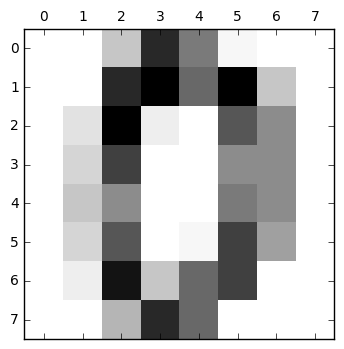

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
plt.matshow(digits.images[0], cmap=plt.cm.Greys);

In [8]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2],[1, 4],[1, 0],[4, 2],[4, 4],[4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print "Cluster label: ", kmeans.labels_
print "Centroid: ", kmeans.cluster_centers_
print "Predictions: ",kmeans.predict([[0, 0], [4, 4]])

Cluster label:  [0 0 0 1 1 1]
Centroid:  [[ 1.  2.]
 [ 4.  2.]]
Predictions:  [0 1]


## S.12 그래프 분석

* 그래프를 분석하려면 GraphFrame을 사용한다.
```
http://graphframes.github.io/quick-start.html
```

* 더 해보기
    * link prediction - similarities
    * communities - clustering
    * opinion leader - PageRank
    * graph partitioning

* 참고 논문: "Social big data: Recent achievements and new challenges"

* spark-defaults.conf 수정
    * 여러 jar가 필요한 경우, 컴마로 분리해서 추가한다.
```
$vim conf/spark-defaults.conf 
spark.jars.packages=graphframes:graphframes:0.4.0-spark2.0-s_2.11
```


In [5]:
#v = sqlContext.createDataFrame([
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
# Create an Edge DataFrame with "src" and "dst" columns
#e = sqlContext.createDataFrame([
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

+---+--------+
| id|inDegree|
+---+--------+
|  c|       1|
|  b|       2|
+---+--------+



2

In [ ]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").show()

## 문제 S-4: spark-submit

* GraphFrame을 spark-submit으로 실행한다.
* spark-defaults.conf에 추가
```
spark.jars.packages=graphframes:graphframes:0.4.0-spark2.0-s_2.11
```

In [9]:
%%writefile src/ds_spark_graphframe.py
#!/usr/bin/env python
# coding: utf-8
import pyspark
from graphframes import *
def doIt():
    v = spark.createDataFrame([
      ("a", "Alice", 34),
      ("b", "Bob", 36),
      ("c", "Charlie", 30),
    ], ["id", "name", "age"])
    # Create an Edge DataFrame with "src" and "dst" columns
    e = spark.createDataFrame([
      ("a", "b", "friend"),
      ("b", "c", "follow"),
      ("c", "b", "follow"),
    ], ["src", "dst", "relationship"])
    # Create a GraphFrame
    # Query: Get in-degree of each vertex.
    g = GraphFrame(v, e)
    g.inDegrees.show()
    # Query: Count the number of "follow" connections in the graph.
    g.edges.filter("relationship = 'follow'").count()
    # Run PageRank algorithm, and show results.
    results = g.pageRank(resetProbability=0.01, maxIter=20)
    results.vertices.select("id", "pagerank").show()

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()  
    doIt()
    spark.stop()


Overwriting src/ds_spark_graphframe.py


In [10]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_graphframe.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

## 연습: 더 해보기

* todo
    * spark 이미지 처리 http://docs.thunder-project.org/spark